# PK Modelling Project - Mirtazapine
Using LINEAR kinetics to better match sample data

In [1]:
# Import basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle

# Import local scikit-pk (skpk) library - https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
sys.path.append(r'C:\Users\klty0\Desktop\scikit-pk\src')
#sys.path.append(r'C:\Users\Kenneth Leung\Desktop\scikit-pk\src')

import skpk

# Import ODE modules
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import differential_evolution, shgo, basinhopping

np.set_printoptions(suppress=True)

In [2]:
# Graph settings
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Neue Einstellung'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 12
mpl.rc('axes', titlesize=18, titleweight=20, labelsize=14, facecolor=[0.9,0.9,0.9], edgecolor=[0.5, 0.5, 0.5], linewidth=0.5)
mpl.rc('xtick', labelsize=12, color=[0.3,0.3,0.3])
mpl.rc('ytick', labelsize=12)
mpl.rc('lines', linewidth=3, markersize=10)
mpl.rc('legend', fontsize=12, loc = 'upper left')
mpl.rc('axes', axisbelow=True)
savefigOpts = {'dpi': 100, 'transparent': True}

font_dirs = [r'C:\Users\klty0\Dropbox\Holmusk\Holmusk Templates\Fonts', ]
#font_dirs = [r'C:\Users\Kenneth Leung\Dropbox\Holmusk\Holmusk Templates\Fonts', ]
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = mpl.font_manager.createFontList(font_files)
mpl.font_manager.fontManager.ttflist.extend(font_list)

In [3]:
color_scheme = ['#11151D', '#3360CC', '#77B55B'] #Black, Blue, Green

#### Data Preparation
Creating list of lists with elements [subject_id, gender, age mean, age std]  
For gender, 0 = Male and 1 = Female

In [4]:
list_of_attr = [
    [1,0,24,4],
    [2,0,25,5],
    [3,0,25,4], 
    [4,0,51,8], 
    [5,0,68,5], 
    [6,0,33,6], 
    [7,0,69,3], 
    [8,0,21,1], 
    [9,0,23,4], 
    [10,0,27,9], 
    [11,0,28,6], 
    [12,0,22,1], 
    [13,1,23,3], 
    [14,1,51,4], 
    [15,1,40,8], 
    [16,1,68,3], 
    [17,1,23,6],
    [18,0,23,4],
    [19,0,25,4],
    [20,0,25,4],
    [21,0,32,4],
    [22,0,33,6],
    [23,0,69,3],
    [24,0,23,4],
    [25,0,24,4],
    [26,0,25,4],
    [27,0,26,7],
    [28,0,29,7],
    [29,0,30,8],
    [30,0,33,7],
    [31,0,32,4],
    [32,0,23,4],
    [33,0,25,4],
    [34,0,32,4],
    [35,0,23,4],
    [36,0,25,4],
    [37,0,25,4],
    [38,0,23,4],
    [39,1,40,8],
    [40,1,68,3],
    [41,1,23,4],
    [42,1,34,10],
    [50,1,27.5,7.4],
    [51,0,27.8,5.8]
]

In [5]:
df_attr = pd.DataFrame(list_of_attr, columns = ['subject_id','female','age_mean','age_sd'])

In [6]:
# Create dataframe of PK parameters (Subject ID, Cmax mean, Cmax SD, Tmax mean, Tmax SD, AUC mean, AUC SD, Study Reference, Freq, Dose)
list_of_pk_paras = [
    [1, 32.3, 11.4, 1.65, 0.70, 345, 103, 20, 'Single', 15],
    [2, 32.5, 9.7, 1.50, 0.60, 281, 83, 21, 'Single', 15],
    [3, 31.6, 12.8, 1.82, 0.71, 216, 46, 22, 'Single', 15],
    [4, 42.5, 16.3, 1.20, 0.30, 362, 66, 23, 'Single', 15],
    [5, 40.6, 13.8, 1.45, 0.73, 486, 161, 24, 'Single', 15],
    [6, 32.1, 8.1, 1.67, 0.65, 355, 199, 25, 'Single', 20],
    [7, 48.4, 20.1, 1.59, 0.74, 647, 294, 25, 'Single', 20],
    [8, 67.7, 20.6, 1.04, 0.10, 459, 136, 26, 'Single', 30],
    [9, 74.4, 23.5, 1.41, 0.74, 614, 177, 27, 'Single', 30],
    [10, 56.1, 13.9, 1.42, 0.56, 562, 134, 28, 'Single', 30],
    [11, 74.5, 37.8, 1.53, 0.78, 570, 137, 29, 'Single', 30],
    [12, 113.0, 55.8, 1.21, 0.40, 808, 285, 26, 'Single', 45],
    [13, 42.0, 8.2, 1.58, 0.68, 445, 94, 21, 'Single', 15],
    [14, 24.7, 6.9, 1.80, 0.80, 397, 218, 23, 'Single', 15],
    [15, 36.9, 11.3, 1.72, 1.00, 673, 248, 25, 'Single', 20],
    [16, 45.6, 20.2, 2.03, 1.64, 770, 270, 25, 'Single', 20],
    [17, 88.8, 38.7, 2.09, 1.84, 950, 298, 29, 'Single', 30],
    [18, 34.2, 13.4, 1.54, 0.51, 294, 100, 30, 'Multiple', 15],
    [19, 39.0, 12.0, 2.20, 1.50, 409, 116, 31, 'Multiple', 15],
    [20, 41.8, 7.7, 1.47, 0.75, 252, 48, 22, 'Multiple', 15],
    [21, 30.6, 7.8, 2.02, 1.11, 282, 51, 32, 'Multiple', 15],
    [22, 45.9, 24.3, 1.33, 0.43, 386, 170, 25, 'Multiple', 20],
    [23, 51.6, 29.4, 2.41, 1.66, 693, 357, 25, 'Multiple', 20],
    [24, 84.2, 36.5, 1.62, 0.82, 618, 205, 30, 'Multiple', 30],
    [25, 76.0, 33.0, 1.99, 1.65, 589, 142, 33, 'Multiple', 30],
    [26, 80.0, 24.0, 2.60, 1.40, 900, 254, 31, 'Multiple', 30],
    [27, 55.0, 8.9, 2.96, 1.24, 630, 160, 34, 'Multiple', 30],
    [28, 80.4, 18.5, 1.10, 0.30, 706, 235, 35, 'Multiple', 30],
    [29, 62.5, 15.8, 2.10, 1.08, 635, 196, 36, 'Multiple', 30],
    [30, 89.0, 21.0, 1.36, 0.39, 761, 140, 37, 'Multiple', 30],
    [31, 63.8, 16.8, 2.08, 0.93, 553, 96, 32, 'Multiple', 30],
    [32, 118.3, 47.3, 1.33, 0.85, 908, 308, 30, 'Multiple', 45],
    [33, 113.0, 29.0, 2.90, 1.80, 1350, 353, 31, 'Multiple', 45],
    [34, 102.1, 37.5, 1.79, 1.03, 786, 176, 32, 'Multiple', 45],
    [35, 141.2, 40.6, 1.06, 0.24, 1135, 247, 30, 'Multiple', 60],
    [36, 158.0, 41.0, 2.70, 1.60, 1793, 447, 31, 'Multiple', 60],
    [37, 181.0, 44.0, 3.10, 1.70, 2149, 476, 31, 'Multiple', 75],
    [38, 227.5, 31.1, 1.67, 0.58, 1797, 446, 30, 'Multiple', 80],
    [39, 59.9, 21.4, 2.33, 1.62, 769, 234, 25, 'Multiple', 20],
    [40, 62.0, 27.6, 2.31, 1.43, 860, 238, 25, 'Multiple', 20],
    [41, 81.7, 26.9, 2.29, 1.03, 958, 272, 34, 'Multiple', 30],
    [42, 80.0, 16.0, 1.39, 0.42, 785, 173, 37, 'Multiple', 30],
    [50, 181.1, 21.2, 0.5, 0.0, 814.5, 339.5, 50,'Single', 30],
    [51, 160.6, 36.4, 0.6, 0.2, 565.3, 169.5, 50,'Single', 30]
]

In [7]:
df_pk_paras = pd.DataFrame(list_of_pk_paras, columns = ['subject_id','Cmax_mean','Cmax_sd','Tmax_mean','Tmax_sd',
                                                        'AUC_mean','AUC_sd','reference','dosing', 'dose'])

In [8]:
df_subject_master = df_pk_paras.merge(df_attr, on = 'subject_id')
df_subject_master['V1'] = [152 if x == 'Single' else 107 for x in df_subject_master['dosing']]
df_subject_master

,subject_id,Cmax_mean,Cmax_sd,Tmax_mean,Tmax_sd,AUC_mean,AUC_sd,reference,dosing,dose,female,age_mean,age_sd,V1
0,1,32.3,11.4,1.65,0.70,345.0,103.0,20,Single,15,0,24.0,4.0,152
1,2,32.5,9.7,1.50,0.60,281.0,83.0,21,Single,15,0,25.0,5.0,152
2,3,31.6,12.8,1.82,0.71,216.0,46.0,22,Single,15,0,25.0,4.0,152
3,4,42.5,16.3,1.20,0.30,362.0,66.0,23,Single,15,0,51.0,8.0,152
4,5,40.6,13.8,1.45,0.73,486.0,161.0,24,Single,15,0,68.0,5.0,152
5,6,32.1,8.1,1.67,0.65,355.0,199.0,25,Single,20,0,33.0,6.0,152
6,7,48.4,20.1,1.59,0.74,647.0,294.0,25,Single,20,0,69.0,3.0,152
7,8,67.7,20.6,1.04,0.10,459.0,136.0,26,Single,30,0,21.0,1.0,152
8,9,74.4,23.5,1.41,0.74,614.0,177.0,27,Single,30,0,23.0,4.0,152
9,10,56.1,13.9,1.42,0.56,562.0,134.0,28,Single,30,0,27.0,9.0,152


#### Read in real data (from literature)

In [9]:
path = '.\Samples\Multiple Dosing'
files = os.listdir(path)
files_xls = [f for f in files if f[-4:] == 'xlsx']

In [10]:
files_xls

['subject19_ref31_15mg_mod.xlsx',
 'subject20_ref22_mod.xlsx',
 'subject22_ref25_adults_males_multi_20mg_mod.xlsx',
 'subject23_ref25_elderly_males_multi_20mg_mod.xlsx',
 'subject25_ref33_30mg_mod.xlsx',
 'subject26_ref31_30mg_mod.xlsx',
 'subject33_ref31_45mg_mod.xlsx',
 'subject36_ref31_60mg_mod.xlsx',
 'subject37_ref31_75mg_mod.xlsx',
 'subject39_ref25_adults_females_multi_20mg_mod.xlsx',
 'subject40_ref25_elderly_females_multi_20mg_mod.xlsx']

In [11]:
list_of_raw_df = []

for file in files_xls:
    data = pd.read_excel(f'./Samples/Multiple Dosing/{file}')
    df = pd.DataFrame(data)
    df['time'] = round(df['time'],3)
    list_of_raw_df.append(df)

In [12]:
# 11 cohort subjects with real raw time-conc data
subject_id_list = [19,20,22,23,25,26,33,36,37,39,40]

In [13]:
list_of_samples = dict(zip(subject_id_list, list_of_raw_df))

In [14]:
period_start = 0
period_end = 120
intervals = 961 # Setting intervals to create intervals of 0.125h
time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=3)

In [15]:
list_of_samples

{19:      time       conc
 0    0.00   7.229920
 1    0.25   7.479224
 2    0.50   9.972299
 3    0.75  18.199400
 4    1.00  22.936288
 5    1.50  30.664820
 6    2.00  32.409972
 7    3.00  30.466205
 8    4.00  27.175208
 9    5.00  24.681400
 10   6.00  21.689751
 11   8.00  19.944598
 12  11.00  15.955679
 13  15.00  12.465374
 14  24.00   7.977839,
 20:       time      conc
 0    0.000   4.01301
 1    0.500   6.48849
 2    0.750  18.38440
 3    1.000  38.42020
 4    1.250  53.25850
 5    1.375  50.84170
 6    1.500  47.35920
 7    2.000  32.99720
 8    2.500  24.93080
 9    3.000  21.09790
 10   4.000  15.25170
 11   5.000  14.47360
 12   7.000  12.35130
 13   9.000   9.22670
 14  12.000   5.85692
 15  16.000   6.14909
 16  24.000   4.08384
 17  36.000   1.42717
 18  48.000   1.09918
 19  60.000   0.60920,
 22:       time       conc
 0     0.00   7.178751
 1     0.25   7.617330
 2     0.50  19.215800
 3     0.75  32.396600
 4     1.00  38.018606
 5     1.25  39.910871
 6     1.75

In [16]:
prior_doses = [5,7,7,7,7,5,5,5,5,7,7]
five_prior_doses = [19,26,33,36,37]
seven_prior_doses = [20,22,23,25,39,40]

In [17]:
subject_prior_doses = dict(zip(subject_id_list, prior_doses))

In [18]:
all_time_points = [0,24,48,72,96,120,144,168]

In [19]:
# Adjusting the time points based on the number of prior doses received (for multiple dosing)
for i in list_of_samples:
    if i in five_prior_doses:
        list_of_samples[i]['time'] = list_of_samples[i]['time'] + 96
    if i in seven_prior_doses:
        list_of_samples[i]['time'] = list_of_samples[i]['time'] + 144
#     if i in six_prior_doses:
#         list_of_samples[i]['time'] = list_of_samples[i]['time'] + 120

In [20]:
for i in list_of_samples:  
    if list_of_samples[i]['time'][0] != 0.0:
        new_row = pd.DataFrame({'time':0.0, 'conc':0.0}, index =[0])
        list_of_samples[i] = pd.concat([new_row, list_of_samples[i][:]]).reset_index(drop = True)
    else:
        pass

In [21]:
list_of_samples

{19:       time       conc
 0     0.00   0.000000
 1    96.00   7.229920
 2    96.25   7.479224
 3    96.50   9.972299
 4    96.75  18.199400
 5    97.00  22.936288
 6    97.50  30.664820
 7    98.00  32.409972
 8    99.00  30.466205
 9   100.00  27.175208
 10  101.00  24.681400
 11  102.00  21.689751
 12  104.00  19.944598
 13  107.00  15.955679
 14  111.00  12.465374
 15  120.00   7.977839,
 20:        time      conc
 0     0.000   0.00000
 1   144.000   4.01301
 2   144.500   6.48849
 3   144.750  18.38440
 4   145.000  38.42020
 5   145.250  53.25850
 6   145.375  50.84170
 7   145.500  47.35920
 8   146.000  32.99720
 9   146.500  24.93080
 10  147.000  21.09790
 11  148.000  15.25170
 12  149.000  14.47360
 13  151.000  12.35130
 14  153.000   9.22670
 15  156.000   5.85692
 16  160.000   6.14909
 17  168.000   4.08384
 18  180.000   1.42717
 19  192.000   1.09918
 20  204.000   0.60920,
 22:       time       conc
 0     0.00   0.000000
 1   144.00   7.178751
 2   144.25   7.6173

#### Generate dataframe and reformat into clearer columns

In [22]:
def format_de_dataframe(de):
    df_de_results = pd.DataFrame(de, columns = ['subject_id', 'k_values', 'error', 'bounds'])
    df_de_results.loc[:, 'ka'] = df_de_results['k_values'].map(lambda x: x[0])
    df_de_results.loc[:, 'k12'] = df_de_results['k_values'].map(lambda x: x[1])
    df_de_results.loc[:, 'k21'] = df_de_results['k_values'].map(lambda x: x[2])
    df_de_results.loc[:, 'ke'] = df_de_results['k_values'].map(lambda x: x[3])
    df_de_results.drop(columns = 'k_values')
    df_de_results_final = df_de_results.merge(df_subject_master, on = 'subject_id')
    return df_de_results_final

## Fixing KM

#### Single Dosing

In [23]:
# Instantiate the relevant compartment instances of the 2-compartment model
C0 = skpk.Cmt(0, 'Absorption (GI Tract)')
C1 = skpk.Cmt(1, 'Central')
C2 = skpk.Cmt(2, 'Peripheral')
C3 = skpk.Cmt(3, 'External / Elimination')

pkmodel = skpk.Model('PK Model - Test')
pkmodel.add_cmt([C0, C1, C2, C3])

0-Absorption (GI Tract) compartment successfully generated
1-Central compartment successfully generated
2-Peripheral compartment successfully generated
3-External / Elimination compartment successfully generated
 Model named PK Model - Test successfully generated


In [24]:
# Initial parameters
F = 0.497 # Bioavailability
n = 3 # Number of compartments (inclusive of GI tract)
time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=3)

In [25]:
V1_multi = 107 # Central volume of distribution for multiple dosing

In [26]:
# Define dcdt function of ODE (dot multiplication of coefficient matrix and concentration)
def dC(t,C,A):
   
    # Dot multiplication of A coefficient matrix (n x n) with concentration vector C (n x 1) 
    dCdt = np.dot(A, C)
    
    # Returns dCdt as n x 1 vector (dC0/dt, dC1/dt, dC2/dt)
    return dCdt

In [27]:
def ode_solver(p, subject_id, period_start, period_end, C_initial):
    
    ka, k12, k21, ke = p

    intervals = ((period_end - period_start) * 8) + 1
    
    time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=3)

    # Add links based on parameters (p) passed as arguments
    pkmodel.add_link([(C0, C1, ka), (C1, C2, k12), (C2, C1, k21), (C1, C3, ke)])
    full_matrix = pkmodel.get_matrix()
    
    # Ignoring elimination compartment (C3), so we truncate matrix size by 1 to form coefficient matrix (n is exclusive)
    A_matrix = full_matrix[0:n,0:n]

    output = solve_ivp(fun=dC, t_span=[period_start, period_end], y0 = C_initial, t_eval = time_horizon, 
                   args=(A_matrix,))
    return output

In [28]:
def objective_func(p, subject_id):
    
    # Setup timepoints
    time_points = all_time_points[:subject_prior_doses[subject_id]] # Add the dosing time points
    final_timepoint = int(list_of_samples[subject_id]['time'].values[-1]) # Final data timepoint where trajectory ends
    time_points.append(final_timepoint)
    n_timepoints = len(time_points)
    
    # Initial concentration
    dose_mg = df_subject_master[df_subject_master.subject_id == subject_id]['dose'].values[0]   
    dose_ug = dose_mg * 1000   
    
    C_initial = np.zeros(n)
    C_initial.reshape(n,)
    C_initial[0] = (dose_ug * F)
    C_initial[1] = list_of_samples[subject_id]['conc'][0]
    
    central_conc = []
    t_horizon = []
    
    for i in range(1,n_timepoints):
        period_start = time_points[i-1]
        period_end = time_points[i]

        output = ode_solver(p, subject_id, period_start, period_end, C_initial)
        
        central_conc = np.append(central_conc,output.y[1])
        t_horizon = np.append(t_horizon, output.t)
        
        C_initial[0] = output.y[0][-1] + (dose_ug*F)
        C_initial[1] = output.y[1][-1]
        C_initial[2] = output.y[2][-1]
        
    output_dict = dict(zip(t_horizon, central_conc))

    sample_df = list_of_samples[subject_id]
    t_sample = sample_df['time'].values
    y_pred = [output_dict[t] for t in t_sample] 
    y_actual = sample_df['conc'].values
    
    error = y_actual - y_pred
    normalized_error = error / y_actual.max()
    squared_error = np.power(normalized_error,2)
    sum_error = np.sum(squared_error)
    mse = sum_error / y_actual.shape[0]

    Cmax_pred = np.amax(output.y[1])
    Cmax_pred_index = np.where(output.y[1] == Cmax_pred)[0][0]
    Tmax_pred = output.t[Cmax_pred_index]
    Cmax_actual = sample_df['conc'].max()
    Tmax_actual = sample_df.iloc[sample_df['conc'].argmax(), :1].values[0]
    Cmax_diff = np.abs(Cmax_actual - Cmax_pred)
    Tmax_diff = np.abs(Tmax_actual - Tmax_pred)
    Cmax_limit = 0.04 * Cmax_actual # Allow up to 4% variation
    Tmax_limit = 0.04 * Tmax_actual
    if Cmax_diff < Cmax_limit:
        Cmax_penalty = Cmax_diff
        Tmax_penalty = Tmax_diff
    else:
        Cmax_penalty = np.square(Cmax_diff)
        Tmax_penalty = np.square(Tmax_diff)
    total_penalty = Cmax_penalty + Tmax_penalty
    total_error = mse + (0.0012 * total_penalty) # Add weights
    return total_error

In [29]:
# Plot best fit from best results (differential evolution)
def plot_best_fit(p, subject_id):
    
    # Setup timepoints
    time_points = all_time_points[:subject_prior_doses[subject_id]] # Add the dosing time points
    final_timepoint = int(list_of_samples[subject_id]['time'].values[-1]) # Final data timepoint where trajectory ends
    time_points.append(final_timepoint)
    n_timepoints = len(time_points)
    
    # Initial concentration
    dose_mg = df_subject_master[df_subject_master.subject_id == subject_id]['dose'].values[0]   
    dose_ug = dose_mg * 1000   
    
    C_initial = np.zeros(n)
    C_initial.reshape(n,)
    C_initial[0] = (dose_ug * F)
    C_initial[1] = list_of_samples[subject_id]['conc'][0]
    
    central_conc = []
    peripheral_conc = []
    t_horizon = []
    
    for i in range(1,n_timepoints):
        period_start = time_points[i-1]
        period_end = time_points[i]

        output = ode_solver(p, subject_id, period_start, period_end, C_initial)
        
        central_conc = np.append(central_conc,output.y[1])
        peripheral_conc = np.append(peripheral_conc,output.y[2])
        t_horizon = np.append(t_horizon, output.t)
        
        C_initial[0] = output.y[0][-1] + (dose_ug*F)
        C_initial[1] = output.y[1][-1]
        C_initial[2] = output.y[2][-1]
    
    plt.figure(figsize=(10,5))
    plt.xlabel('Time (h)')
    plt.ylabel('Plasma concentration (ug/L)')
    plt.title(f'Cohort ID = {subject_id}')
    plt.plot(t_horizon,central_conc, color = color_scheme[1], label = 'Central concentration')
    #plt.plot(t_horizon,peripheral_conc, color = color_scheme[2], label = 'Peripheral concentration')
    print(f'Central Cmax = {np.amax(output.y[1])}, Peripheral Cmax = {np.amax(output.y[2])}')
    plt.legend()
    plt.scatter(list_of_samples[subject_id]['time'], list_of_samples[subject_id]['conc'], color = color_scheme[0], s = 25)
    plt.savefig(f'./Images/15 Raw Trajectories/Linear Kinetics Subject ID {subject_id}.png', **savefigOpts)

In [30]:
bounds = [(0.01, 25.0), (0.01, 80.0), (1.0, 60.0),(0.1, 30.0)]

In [31]:
de_results_multi = []

for subject_id in subject_id_list:
    start = time.perf_counter()
    
    best_result = differential_evolution(objective_func, bounds, strategy='best2bin', popsize = 8,
                                         recombination=0.8, mutation = (0,1), maxiter = 75, tol = 0.0008,
                                         args = (subject_id,), seed = 42)
    
    de_results_multi.append([subject_id, best_result.x, best_result.fun, bounds])
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)
    print(f'Bounds: {bounds}')

19 DE completed in 1344.5 seconds
[ 0.09831994 79.53799522  3.75851342 19.306146  ] 0.018530444725991184
Bounds: [(0.01, 25.0), (0.01, 80.0), (1.0, 60.0), (0.1, 30.0)]
20 DE completed in 1340.4 seconds
[ 0.2136899   0.01098591 47.49043107 29.99962167] 0.05580817169537684
Bounds: [(0.01, 25.0), (0.01, 80.0), (1.0, 60.0), (0.1, 30.0)]
22 DE completed in 1658.75 seconds
[ 0.11705759 79.48845609  5.89916698 25.97401361] 0.020624231494135017
Bounds: [(0.01, 25.0), (0.01, 80.0), (1.0, 60.0), (0.1, 30.0)]
23 DE completed in 2260.64 seconds
[ 0.06330312 79.47493124  3.76093255 15.42674609] 0.0174906513027439
Bounds: [(0.01, 25.0), (0.01, 80.0), (1.0, 60.0), (0.1, 30.0)]
25 DE completed in 1826.01 seconds
[ 0.11471713 79.98891774  4.04132978 24.85155195] 0.02688723103118338
Bounds: [(0.01, 25.0), (0.01, 80.0), (1.0, 60.0), (0.1, 30.0)]
26 DE completed in 966.43 seconds
[ 0.09398327 79.88258186  3.67019257 16.97845152] 0.018145829598943987
Bounds: [(0.01, 25.0), (0.01, 80.0), (1.0, 60.0), (0.1, 

Central Cmax = 31.11897363767346, Peripheral Cmax = 656.4052165824824
Central Cmax = 51.128204423840245, Peripheral Cmax = 0.011834138457880764
Central Cmax = 38.31812760189232, Peripheral Cmax = 514.684403107586
Central Cmax = 41.222908433675464, Peripheral Cmax = 869.5307370272892
Central Cmax = 55.53924348264214, Peripheral Cmax = 1094.041233288354
Central Cmax = 67.37745389240818, Peripheral Cmax = 1462.7455554026321
Central Cmax = 97.22983570283311, Peripheral Cmax = 2842.7813097937847
Central Cmax = 128.8942614326889, Peripheral Cmax = 3811.732649054514
Central Cmax = 151.07880085341776, Peripheral Cmax = 3941.664139876048
Central Cmax = 48.74147947925167, Peripheral Cmax = 457.70258024111405
Central Cmax = 52.54025645926674, Peripheral Cmax = 448.84048975359383


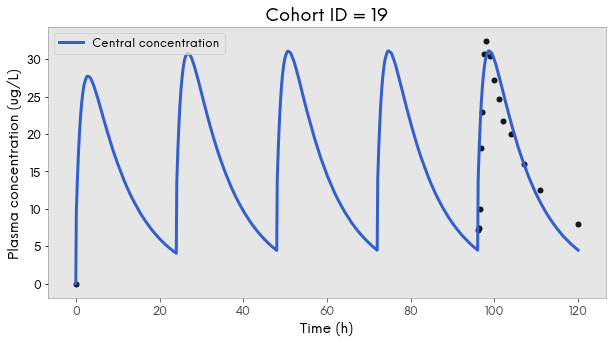

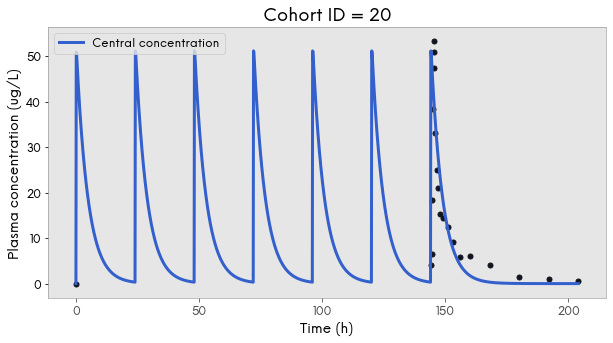

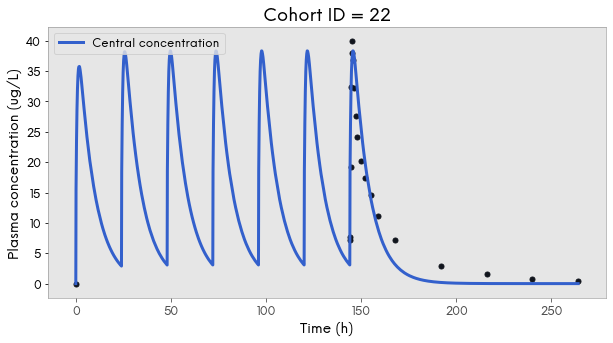

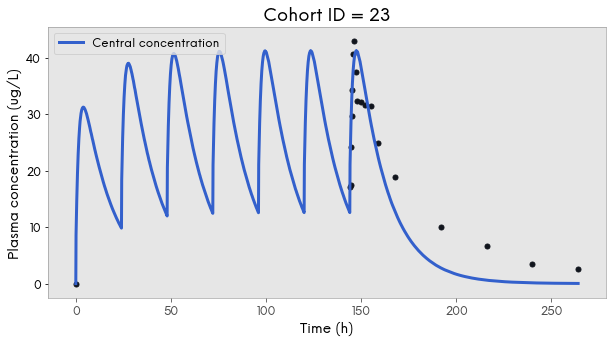

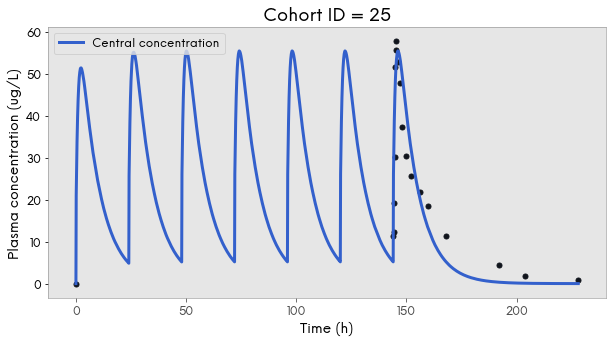

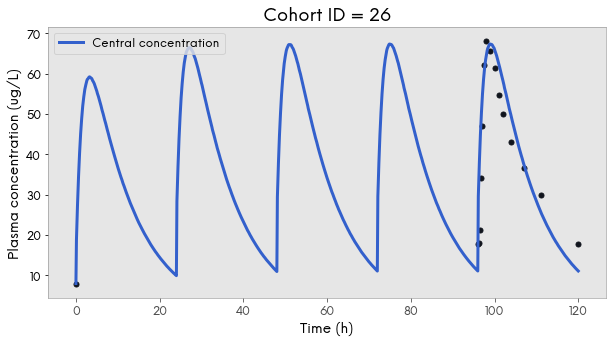

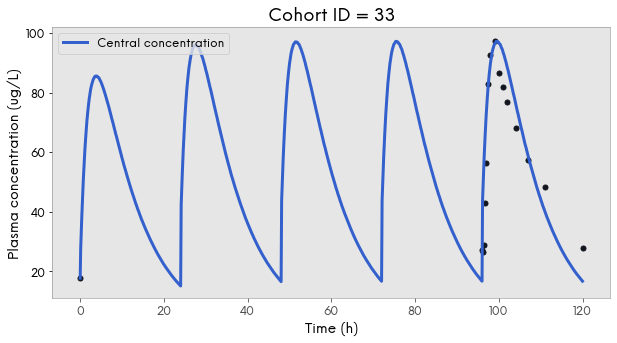

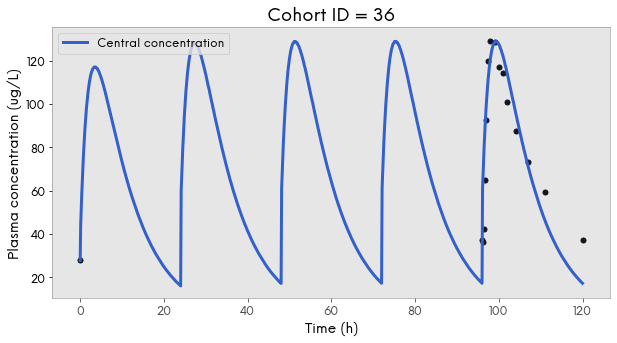

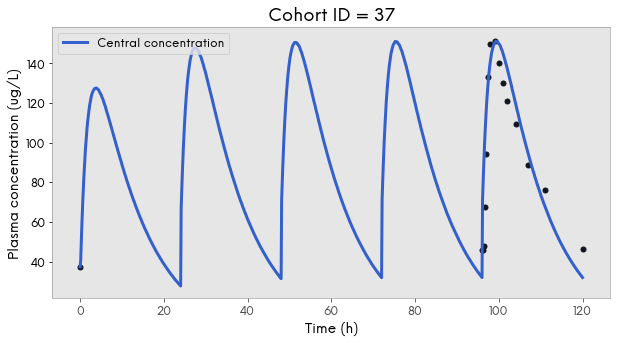

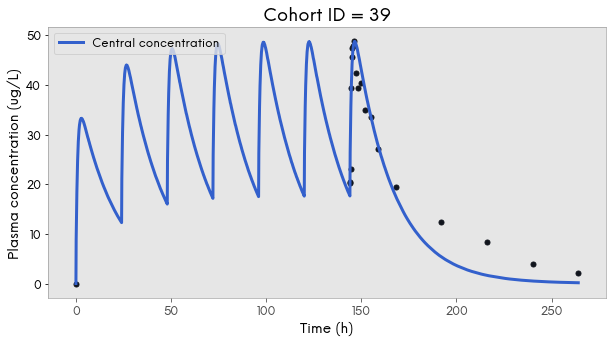

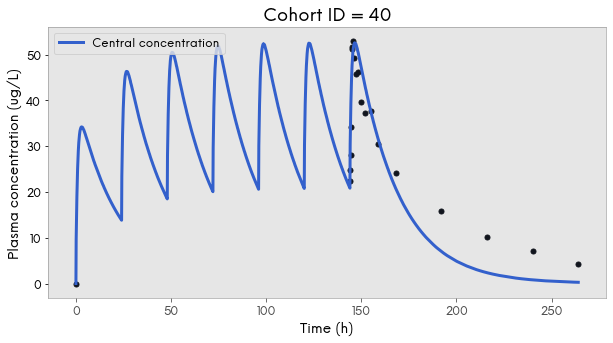

In [32]:
df_multi = format_de_dataframe(de_results_multi)
for subject_id in df_multi.subject_id.values:
    k_values = list(df_multi[df_multi.subject_id == subject_id][['ka','k12','k21','ke']].values[0])
    plot_best_fit(k_values, subject_id)